In [1]:
import os
from datasets import load_dataset, load_from_disk
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

ROOT = '../data'
DATASET_ID = 'tulu'
DATA_DIR = f'{ROOT}/{DATASET_ID}'

/Users/pierrelardet/anaconda3/envs/mnlp-project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Tulu

In this notebook, we explore and filter the Tulu SFT dataset.

HF: https://huggingface.co/datasets/allenai/tulu-v2-sft-mixture

Paper: https://arxiv.org/abs/2311.10702

In [2]:

if not os.path.isdir(DATA_DIR):
    tulu_hf = load_dataset('allenai/tulu-v2-sft-mixture')
    tulu_hf = tulu_hf['train']
    tulu_hf.save_to_disk(DATA_DIR)
else:
    tulu_hf = load_from_disk(DATA_DIR)

Let's convert to pandas for easier inspection.

In [3]:
tulu = tulu_hf.to_pandas()

# Remove their hard coded examples
tulu = tulu[tulu['dataset'] != 'hard_coded']

tulu.columns, tulu['dataset'].unique()

(Index(['dataset', 'id', 'messages'], dtype='object'),
 array(['flan_v2', 'cot', 'oasst1', 'lima', 'gpt4_alpaca', 'code_alpaca',
        'sharegpt', 'wizardlm', 'open_orca', 'science.evidence_inference',
        'science.qasper_truncated_4000', 'science.scifact_json',
        'science.scitldr_aic', 'science.scierc_ner',
        'science.scierc_relation'], dtype=object))

Let's flattent the `messages` column.

In [4]:
def convert_to_prompt(messages):
    prompt = ''
    for message in messages:
        prompt += message['role'].upper() + ': '
        prompt += message['content'] + '\n'
    return prompt

tulu['prompt'] = tulu['messages'].apply(convert_to_prompt)
tulu = tulu.drop(columns=['messages'])
tulu.head()
    

,dataset,id,prompt
0,flan_v2,flan_v2_0,"USER: Question: Gdańsk (, ; German: """" , ) is ..."
1,flan_v2,flan_v2_1,"USER: Q: A.S. Roma, chairman, James Pallotta; ..."
2,flan_v2,flan_v2_2,USER: Write a movie review.\nconfidently \nWri...
3,flan_v2,flan_v2_3,"USER: Problem: Data: name = Midsummer House, e..."
4,flan_v2,flan_v2_4,"USER: How is ""The old fortifications at Handak..."


How long is each dataset?

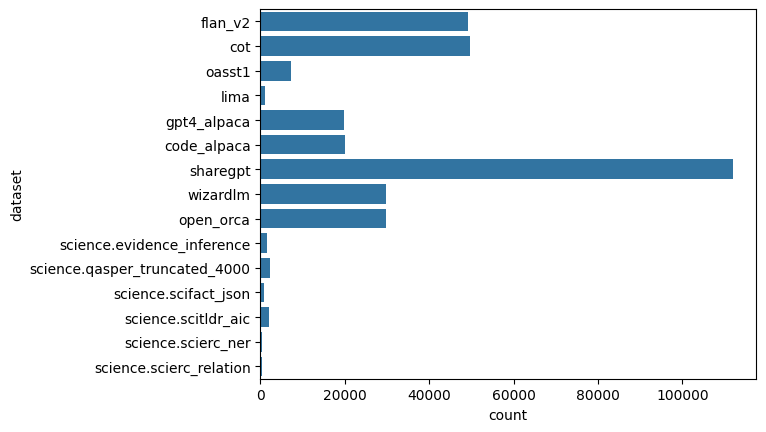

In [5]:
# Barchart of lengths of TULU datasets
sns.countplot(tulu, y='dataset')
plt.show()

In [6]:
# For each dataset print the number of examples
for dataset in tulu['dataset'].unique():
    print(f'{dataset}: {len(tulu[tulu["dataset"] == dataset])}')

flan_v2: 49123
cot: 49747
oasst1: 7331
lima: 1018
gpt4_alpaca: 19906
code_alpaca: 20016
sharegpt: 111912
wizardlm: 29810
open_orca: 29683
science.evidence_inference: 1674
science.qasper_truncated_4000: 2218
science.scifact_json: 919
science.scitldr_aic: 1959
science.scierc_ner: 349
science.scierc_relation: 349


In [7]:

tulu['dataset'].unique()

array(['flan_v2', 'cot', 'oasst1', 'lima', 'gpt4_alpaca', 'code_alpaca',
       'sharegpt', 'wizardlm', 'open_orca', 'science.evidence_inference',
       'science.qasper_truncated_4000', 'science.scifact_json',
       'science.scitldr_aic', 'science.scierc_ner',
       'science.scierc_relation'], dtype=object)

Now we can exemplify filtering for a subset of datasets.

In [8]:
subset = list(tulu['dataset'].unique())[:4]
subset

['flan_v2', 'cot', 'oasst1', 'lima']

In [9]:
tulu_subset = tulu[tulu['dataset'].isin(subset)]
len(tulu_subset), tulu_subset['dataset'].unique()

(107219, array(['flan_v2', 'cot', 'oasst1', 'lima'], dtype=object))

Let's have a look at a couple examples from each subset.

In [10]:
# Print 3 examples from each dataset
for dataset in tulu['dataset'].unique():
    print("="*100)
    print(f'{dataset}:')
    print("="*100)
    examples = tulu[tulu['dataset'] == dataset].sample(3)
    for i, example in examples.iterrows():
        print(f'{example["prompt"]}')
        print('-'*50)

flan_v2:
USER: Problem: Un problème majeur est que le programme de partage des En 1997-1998, une tierce frais ne suffit pas à la demande.

Which language is this?
+++++
Language: French


Problem: de l’équipe de l’ARO60 Suis-je obligé de changer mon âge de retraite obligatoire à 60 ans?

Which language is this?
+++++
Language: French


Problem: M. Jabbour a estimé que de nouvelles études devaient être menées pour évaluer l'efficacité des systèmes de quotas de personnes d'ascendance africaine et les facteurs qui tendaient à améliorer leur représentation dans les processus électoraux libres et pluralistes.

Which language is this?
+++++
Language: French


Problem: A noter que le projet prévoit à ce stade, d’intégrer la salle de conférences dans le volume général du bâtiment.

Which language is this?
+++++
Language:
ASSISTANT: French

--------------------------------------------------
USER: Question: Q: How much exercise should a person ideally get during a single day?   A:
Answer: hour



Let's now check how much english is in each subset.
(This was originally run with 1000 samples, but 100 is enough for similar results)

In [19]:
from langdetect import detect

def is_en(text):
    try:
        return detect(text) == 'en'
    except:
        return False
    
# For each dataset print the percentage of English prompts for 1000 samples
for dataset in tulu['dataset'].unique():
    print(f'{dataset}: {tulu[tulu["dataset"] == dataset].sample(100)["prompt"].apply(is_en).mean()}')


flan_v2: 0.77
cot: 1.0
oasst1: 0.3
lima: 1.0
gpt4_alpaca: 1.0
code_alpaca: 0.99
sharegpt: 0.78
wizardlm: 0.99
open_orca: 0.99
science.evidence_inference: 1.0
science.qasper_truncated_4000: 1.0
science.scifact_json: 1.0
science.scitldr_aic: 1.0
science.scierc_ner: 1.0
science.scierc_relation: 1.0
